In [1]:
from __future__ import absolute_import, division, print_function
import sys
import collections 

import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar100, cifar10
from tqdm import tqdm
from IPython.display import clear_output

from scan_tf.models.train import pretext_training, semantic_clustering_training 
from scan_tf.models.resnet import *
import scan_tf.utils.utils as utils
import scan_tf.utils.augmentations as augmentations


# Grow memory to avoid mem overflow
memory_growth=True
if memory_growth:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
      except RuntimeError as e:
        print(e)

In [2]:
# Model configuration
img_width, img_height, img_num_channels = 32, 32, 3
no_epochs = 100
optimizer = tf.keras.optimizers.Adam()
validation_split = 0.2
verbosity = 1

# Load CIFAR-10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train[:10000]
y_train = y_train[:10000]



X_train.shape
input_train = X_train
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Find number of classes dynamically
num_classes = y_train.shape[1]

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

# Normalize data
#X_train = (X_train/255).astype(np.float32)
#X_test = (X_test/255).astype(np.float32)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape : {X_train.shape}")
print(f"y_test shape : {y_test.shape}")

X_train shape: (10000, 32, 32, 3)
y_train shape: (10000, 10)
X_test shape : (10000, 32, 32, 3)
y_test shape : (10000, 10)


In [3]:
backbone_model = resnet_18(n_output=128)
backbone_model.build(input_shape=(None, img_width, img_height, img_num_channels))
backbone_model.summary()

Model: "res_net_type_i"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  9472      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
sequential (Sequential)      multiple                  148736    
_________________________________________________________________
sequential_1 (Sequential)    multiple                  527488    
_________________________________________________________________
sequential_3 (Sequential)    multiple                  2103552   
_________________________________________________________________
sequential_5 (Sequential)    multiple               

<h3>Training for minimizing the Rotation Loss</h3>

In [4]:
pretext_model_save_path="pretext_task_rotnet.h5"
train_pretext = False
if train_pretext:
    pretext_model = pretext_training(backbone_model, X_train, y_train, epochs=50, save_path=pretext_model_save_path)
else:
    pretext_model = backbone_model
    pretext_model.load_weights(pretext_model_save_path)

<h3>Finding Nearest Neighbors (for debugging)</h3>

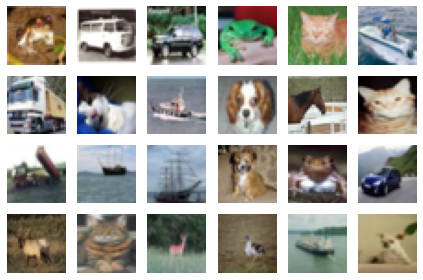

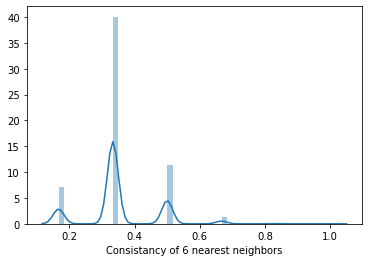

In [5]:
def find_neighbor_consistancy(pretext_model, images, labels, n_neighbors=5, plot=False):
    n_neighbors = 6
    nn = utils.CLusteringNN(pretext_model, n_neighbors=n_neighbors)
    nn.fit(images)
    nn_indexes = nn.get_neighbors_indexes(images)
    
    n = 4
    f, axes = plt.subplots(n, n_neighbors)
    for i, cluster_indexes in enumerate(nn_indexes[:n]):
        for j, im_i in enumerate(cluster_indexes):
            axes[i,j].axis('off')
            axes[i,j].imshow(images[im_i].astype("uint8"))
    plt.tight_layout()
    plt.show()
    
    consistancies = list()
    true_classes = np.argmax(labels, axis=1)
    for cluster_indexes in nn_indexes:
        cluster_classes = true_classes[cluster_indexes]
        # Not sure which formula is better
        consistancy = (cluster_classes[1:]==cluster_classes[0]).sum()/(len(cluster_indexes)-1)
        # Not sure which formula is better
        cluster_label_counter = collections.Counter(cluster_classes)
        consistancy = cluster_label_counter.most_common()[0][1]/len(cluster_indexes)
        consistancies.append(consistancy)
    if plot:
        sns.distplot(consistancies)
        plt.xlabel(f"Consistancy of {n_neighbors} nearest neighbors")
    return consistancies
consistancies = find_neighbor_consistancy(pretext_model, X_train, y_train, n_neighbors=5, plot=True)

## Semantic Clustering

In [10]:
semantic_clustering_model_save_path="semantic_clustering_task.h5"
train_semantic_clustering = True
if train_semantic_clustering:
    semantic_clustering_model = semantic_clustering_training(pretext_model, X_train, y_train, epochs=20, save_path=semantic_clustering_model_save_path)
else:
    semantic_clustering_model = pretext_model
    semantic_clustering_model.load_weights(semantic_clustering_model_save_path)


epoch 0, loss: 0.50 + 1*-2.24=-1.739
epoch 1, loss: 0.24 + 1*-2.09=-1.856
epoch 2, loss: 0.39 + 1*-2.22=-1.829
epoch 3, loss: 0.39 + 1*-2.16=-1.771
epoch 4, loss: 0.36 + 1*-2.23=-1.871
epoch 5, loss: 0.28 + 1*-2.08=-1.801
epoch 6, loss: 0.25 + 1*-2.24=-1.997
epoch 7, loss: 0.41 + 1*-2.25=-1.833
epoch 8, loss: 0.31 + 1*-2.15=-1.839
epoch 9, loss: 0.25 + 1*-2.26=-2.007
epoch 10, loss: 0.31 + 1*-2.23=-1.915
epoch 11, loss: 0.37 + 1*-2.20=-1.834
epoch 12, loss: 0.21 + 1*-2.21=-2.000
epoch 13, loss: 0.21 + 1*-2.23=-2.019
epoch 14, loss: 0.28 + 1*-2.16=-1.883
epoch 15, loss: 0.17 + 1*-2.25=-2.078
epoch 16, loss: 0.47 + 1*-2.21=-1.738
epoch 17, loss: 0.25 + 1*-2.21=-1.966
epoch 18, loss: 0.17 + 1*-2.23=-2.065
epoch 19, loss: 0.14 + 1*-2.22=-2.088


## Hungarian algorithm to match clusters with labels

In [11]:
cluster_probability_associations = semantic_clustering_model.predict(X_train)

In [12]:
from scipy.optimize import linear_sum_assignment
# Run hungarian algorithm for matching
predicted_clusters = np.argmax(cluster_probability_associations, axis=1)
true_labels = np.argmax(y_train, axis=1)

# Create cost matrix
frequencies = np.zeros((cluster_probability_associations.shape[1], y_train.shape[1]))
for i, j in zip(predicted_clusters, true_labels):
    frequencies[i,j] += 1
cost_matrix = -frequencies

# Run Hungarian algo to match clusters
row_ind, col_ind = linear_sum_assignment(cost_matrix)
for match in zip(row_ind, col_ind):
    print(f"Cluster {match[0]} matched with label {match[1]}")

#print(frequencies[col_ind][:, row_ind])
correct_assigned = frequencies[row_ind, col_ind].sum()
print(f"Accuracy: {correct_assigned/np.sum(frequencies)*100:.2f}%")
predicted_labels = np.array(col_ind[np.where(row_ind==cluster)[0][0]] for cluster in predicted_clusters)

Cluster 0 matched with label 7
Cluster 1 matched with label 8
Cluster 2 matched with label 5
Cluster 3 matched with label 3
Cluster 4 matched with label 2
Cluster 5 matched with label 9
Cluster 6 matched with label 6
Cluster 7 matched with label 0
Cluster 8 matched with label 1
Cluster 9 matched with label 4
Accuracy: 14.46%
